# Particle projection example

* Projects particles by distance, projection line and the combined distance and line projection method
* Shows columns in particle tables that change during processing
* All operations are performed in 3D

Usage instructions:
* To ensure everything works properly, all cells from this notebook have to be executed one by one, once each, in order
* Cells that show images can be executed multipe times
* If input files, or processing parameters are changed, all cells in the Projection section have to be executed one by one, once each, in order
  
Prerequisites: 
* Morphological smoothing example (notebook morphological_smoothing.ipynb) has to be executed once before running this notebook in order to generate image used here

## Initialization

In [1]:
import sys
import os

import numpy as np
import scipy as sp
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import pyto
from pyto.particles.relion_star import RelionStar
from pyto.spatial.line_projection import LineProjection
from pyto.spatial.multi_particle_sets import MultiParticleSets
from pyto.spatial.mps_projection import MPSProjection

from common import show_2d_slices 

# convenience
%autosave 0
sys.version

Autosave disabled


'3.13.3 | packaged by conda-forge | (main, Apr 14 2025, 20:44:03) [GCC 13.3.0]'

In [2]:
# Settings

# force showing all rows in a table (default 60 rows)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

# set hostname
hostname = os.uname()[1]
print(f"Host: {hostname}")

Host: rauna


### Definitions

In [3]:
def pack_vectors(
    particles, coordinate_cols=['x_orig', 'y_orig'],
    angle_cols=['rlnAngleRot', 'rlnAngleTilt', 'rlnAnglePsi']):
    """Pack vector coords and directions for matplotlib quiver().

    Coordinates are simply read from the table. Euler angles (in Relion
    convention) are converted to spherical angles (so Rot angle
    is ignored) and then to x and y projections of the unit vector 
    defined by the spherical angles.

    Arguments:
      - particles: (pandas.DataFrame) table containing particle 
        positions and angles
      - coordinate_cols: (list, 2 elements) x and y coordinate 
        column names 
      - angle_cols: (list, 3 elements): Names of columns showing Euler 
        angles in Relion convention (Rot, Tilt and Psi, in this order)

    Returns np.array, size 4 x n_particles) rows are x coordinate,
    y coordinate, unit vector projection on x and unit vector projection
    on y axis (in this order). Columns show values for different
    particles.
    """

    # get coords
    xy = particles[coordinate_cols].values

    # get vector projections
    lp = LineProjection(relion=True, reverse=False)
    angles = particles.loc[:, angle_cols].values
    phis = [lp.find_spherical(ang)[1]  * np.pi / 180 for ang in angles]
    uv = np.asarray([[np.cos(ph), np.sin(ph)] for ph in phis])

    # pack together
    xyuv = np.hstack((xy, uv)).transpose()

    return xyuv

## Projection

### Make region image

In [4]:
# Make regions from the output image of the morphological 
# smoothing example 

# path to the morphologically smoothed region
smooth_path = 'smooth/smooth.mrc'

# path to the projection region image generated here
projection_region_path = 'project/projection_region.mrc'

# read smooth region image
smooth = pyto.segmentation.Labels.read(file=smooth_path)
print(f"Read image {smooth_path}")

# make and save projection region image
region = np.zeros((30, 30, 20), dtype=int)
region[:25, :25, :] = (smooth.data[15:40, 23:48, :] > 1)
image = pyto.segmentation.Labels(data=region)
image.write(file=projection_region_path, dataType='int16')
print(f"Wrote image {projection_region_path}")

Read image smooth/smooth.mrc
Wrote image project/projection_region.mrc


### Read region image

In [5]:
# Read a projection region image
#
# Can be used to read the image generated above, of any other
# binary mrc image (tomo) that contains the projection region

# path to a projection region image 
projection_region_path = 'project/projection_region.mrc'

image = pyto.segmentation.Labels.read(file=projection_region_path)
print(f"Read image {projection_region_path}")

Read image project/projection_region.mrc


### Read particle data

Only one of the two cells of this section should be executed

In [7]:
# Alternative 1: Read pickled particle data object
#
# To be used when particle data are already provided as a
# pyto.spatial.MultiParticleSets object

# path to the MultiParticleSets object
mps_path = "mps.pkl"

mps = MultiParticleSets.read(path=mps_path)

Read  MPS object mps.pkl


In [6]:
# Alternative 2: Read from star file and generate particles object 
#
# To be used when particle data is available in a star file

# star path
star_path = 'particles.star'

# star file table name
table_name = 'data_particles'

# initialize particle object and set star file related attributes
mps = MultiParticleSets()
mps.micrograph_label = 'rlnTomoName'
mps.tablename = table_name
mps.image_label = 'rlnTomoParticleId'

# import star file data
mps.particles = mps.read_star(
    path=star_path, mode='particle', tomo_id_mode=None, 
    tablename=table_name, pixel_size_nm=1, find_region_shape=False)
print(f"Read image {star_path}")
mps.tomos = pd.DataFrame({
    mps.tomo_id_col: mps.particles[mps.tomo_id_col].unique(),
    mps.region_col: projection_region_path})

Read image particles.star


### Show data

In [8]:
# Show tomos table
mps.tomos

,tomo_id,region
0,tomo_1-2,project/projection_region.mrc


In [9]:
# Show particle coordinates and angles

cols = (['tomo_id', 'particle_id'] + mps.orig_coord_cols
        + ['rlnAngleTilt', 'rlnAnglePsi', 'rlnAngleRot'])
mps.particles[cols]

,tomo_id,particle_id,x_orig,y_orig,z_orig,rlnAngleTilt,rlnAnglePsi,rlnAngleRot
0,tomo_1-2,2,15,23,5,90.0,-45.0,0.0
1,tomo_1-2,5,20,15,5,90.0,290.0,0.0
2,tomo_1-2,6,27,10,5,90.0,250.0,0.0


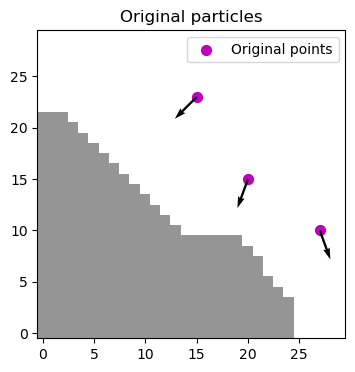

In [10]:
# Plot the projection region and original particles 

markersize = 50
fig, axes = show_2d_slices(
    image=region[:, :, 1:2], vmin=0, vmax=2, figheight=4)
orig_coords = mps.particles[['x_orig', 'y_orig']].values
axes.scatter(
    orig_coords[:, 0], orig_coords[:, 1], color='m',
    s=markersize, label='Original points')
xyuv = pack_vectors(mps.particles)
axes.quiver(*xyuv, scale=10, angles='xy')
axes.legend()
axes.set_title("Original particles");

### Project by distance

In [11]:
# Project by min distance and show original and projected coordinates

mps.orig_coord_reg_frame_cols = mps.orig_coord_cols
mps.particles = mps.convert(
    tomos=mps.tomos, particles=mps.particles, region_id=1)

cols = mps.orig_coord_reg_frame_cols +  mps.coord_reg_frame_cols
mps.particles[cols]

,x_orig,y_orig,z_orig,x_reg_frame,y_reg_frame,z_reg_frame
0,15,23,5,7,16,5
1,20,15,5,19,9,5
2,27,10,5,21,7,5


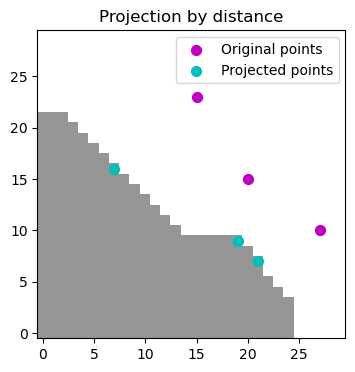

In [12]:
# Plot projection region and particles

markersize = 50
fig, axes = show_2d_slices(
    image=region[:, :, 1:2], vmin=0, vmax=2, figheight=4)
orig_coords = mps.particles[['x_orig', 'y_orig']].values
axes.scatter(
    orig_coords[:, 0], orig_coords[:, 1], color='m',
    s=markersize, label='Original points')
proj_coords = mps.particles[['x_reg_frame', 'y_reg_frame']].values
axes.scatter(
    proj_coords[:, 0], proj_coords[:, 1], color='c',
    s=markersize, label='Projected points')

axes.set_title("Projection by distance")
axes.legend();

### Project by line

In [13]:
# Project by line and show projection coordinates and distance

# membrane normal projection radius (half-width) [pixel]
line_projection_width = [1, 2, 3]

# line projection distance range [pixel]
line_projection_distance = np.arange(50)

# reverse the direction of membrane normals
line_projection_reverse = False

# project by line
mps_project = MPSProjection(
    line_spreads=line_projection_width, not_found=[-1, -1, -1])
mps_project.project_multi(
    mps=mps, coord_cols=mps.orig_coord_cols, 
    distance=line_projection_distance, reverse=line_projection_reverse)

cols = (
    ['tomo_id', 'particle_id'] +  mps.orig_coord_reg_frame_cols
    + [f"{name}_{num}" 
           for num in line_projection_width
           for name in ['x_linep', 'y_linep', 'z_linep', 'linep_dist']])
mps.particles[cols]

,tomo_id,particle_id,x_orig,y_orig,z_orig,x_linep_1,y_linep_1,z_linep_1,linep_dist_1,x_linep_2,y_linep_2,z_linep_2,linep_dist_2,x_linep_3,y_linep_3,z_linep_3,linep_dist_3
0,tomo_1-2,2,15,23,5,8,15,5,10.630146,8,15,5,10.630146,7,16,5,10.630146
1,tomo_1-2,5,20,15,5,18,9,5,6.324555,18,9,5,6.324555,19,9,5,6.082763
2,tomo_1-2,6,27,10,5,-1,-1,-1,30.675723,-1,-1,-1,30.675723,-1,-1,-1,30.675723


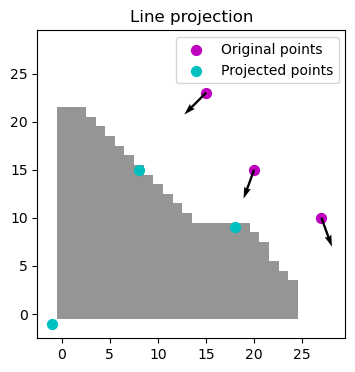

In [14]:
# Plot projection region and particles

# size of the particle marker
markersize = 50

# plot
fig, axes = show_2d_slices(
    image=region[:, :, 1:2], vmin=0, vmax=2, figheight=4)
orig_coords = mps.particles[['x_orig', 'y_orig']].values
axes.scatter(
    orig_coords[:, 0], orig_coords[:, 1], color='m',
    s=markersize, label='Original points')
proj_coords = mps.particles[['x_linep_1', 'y_linep_1']].values
axes.scatter(
    proj_coords[:, 0], proj_coords[:, 1], color='c',
    s=markersize, label='Projected points')
xyuv = pack_vectors(mps.particles)
axes.quiver(*xyuv, scale=10, angles='xy')
axes.legend()
axes.set_title("Line projection");

### Combine distance and line projections

In [15]:
# Find optimal projection and calculate distances

# max projection distance [pixels]
project_dist_max = 40

# projection distances column name
project_dist_col = 'project_dist'

# combine normal projections with min-distance projections and find the optimal 
project_analysis = mps_project.find_best_projections(
    mps=mps, distance_cols=mps.coord_reg_frame_cols)

# calculate distances and exclude those >project_dist_max
mps.short_projected(
    project_dist_col=project_dist_col, project_dist_max=project_dist_max,
    keep_project_dist_col=mps.keep_col, projected_cols=mps.coord_reg_frame_cols,
    non_projected_cols=mps.orig_coord_reg_frame_cols)

In [16]:
# show summary of parojections
project_analysis

,tomo_id,total,unique_1,missed_1,same_1,unique_comb_1,same_comb_1,unique_2,missed_2,same_2,unique_comb_2,same_comb_2,unique_3,missed_3,same_3,unique_comb_3,same_comb_3,best_spread
0,tomo_1-2,3,2,1,0,3,0,2,1,0,3,0,2,1,0,3,0,1


In [17]:
# Show distance related columns

cols = (
   ['tomo_id', 'particle_id'] +  mps.orig_coord_reg_frame_cols
    + ['x_combp', 'y_combp', 'z_combp'] + [project_dist_col])
mps.particles[cols]

,tomo_id,particle_id,x_orig,y_orig,z_orig,x_combp,y_combp,z_combp,project_dist
0,tomo_1-2,2,15,23,5,8,15,5,10.630146
1,tomo_1-2,5,20,15,5,18,9,5,6.082763
2,tomo_1-2,6,27,10,5,21,7,5,6.708204


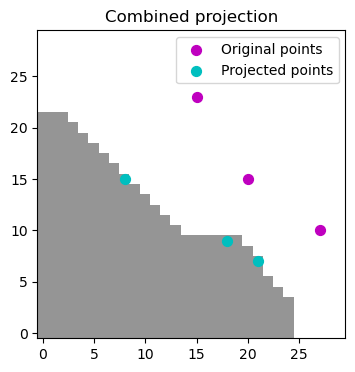

In [18]:
# Plot projection region and particles

markersize = 50
fig, axes = show_2d_slices(
    image=region[:, :, 1:2], vmin=0, vmax=2, figheight=4)
orig_coords = mps.particles[['x_orig', 'y_orig']].values
axes.scatter(
    orig_coords[:, 0], orig_coords[:, 1], color='m',
    s=markersize, label='Original points')
proj_coords = mps.particles[['x_combp', 'y_combp']].values
axes.scatter(
    proj_coords[:, 0], proj_coords[:, 1], color='c',
    s=markersize, label='Projected points')
axes.legend()
axes.set_title("Combined projection");

### Save projected particle data

* Useful for further processing

In [19]:
# Alternative 1: Save as MultiParticleSets object
# Contains projection results and the original particle data
#
# Useful for further Pyto and Pyseg processing

# path to the output MPS oject
mps_out_path = 'project/mps_results.pkl'

mps.write(path=mps_out_path)

Pickled  MPS object to project/mps_results.pkl


In [20]:
# Alternative 2: Save as star file
# Makes star file that is identical to the input star file, except 
# that the x, y and z coordinates are replaced by the projected ones
#
# Useful when further processing requires a star file input
#
# Requires that star_path and table_name are previously defined 
# (e.g.

# path to the output star file
star_out_path = 'project/particles_projected.star'

# projected particle coodrdinate columns
projected_cols = ['x_combp', 'y_combp', 'z_combp']

# read star
rs = pyto.particles.RelionStar()
rs.parse(starfile=star_path, tablename=table_name)

# update coordinates to the projected ones
star_labels = ['rlnCoordinateX',	'rlnCoordinateY',	'rlnCoordinateZ']
rs.data[star_labels] = mps.particles[projected_cols]

# save star
rs.write(starfile=star_out_path, verbose=True)

Wrote star file: project/particles_projected.star
